# Graded assignment 1 - text classification using Genetic Algorithms
## By Abdullah Karagøz

In this assignmetn we'll make a binary text classifier using genetic algorithms. We will classify movie reviews from IMDB as either negative or positive. This task consists of several steps:

1. Preprocessing of the text
2. Genetich Algorithm
3. Validation



## 1. Preprocessing

### 1.1 Uploading data

In [144]:
## Upload the text
import numpy as np
import pandas as pd
import nltk
import string
import re
import math
import random
from scipy import special
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import PlaintextCorpusReader
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [145]:
# File directories
corpus_train_pos_root = 'aclImdb/train/pos/'
corpus_train_neg_root = 'aclImdb/train/neg/'
corpus_test_pos_root = 'aclImdb/test/pos/'
corpus_test_neg_root = 'aclImdb/test/neg/'

# Corpus file objects
files_train_pos = PlaintextCorpusReader(corpus_train_pos_root, '.*')
files_train_neg = PlaintextCorpusReader(corpus_train_neg_root, '.*')
files_test_pos = PlaintextCorpusReader(corpus_test_pos_root, '.*')
files_test_neg = PlaintextCorpusReader(corpus_test_neg_root, '.*')


# Getting review texts, labels and rates all in arrays
# Here we save the labels as one hot encoded arrays so it's easier to make
# calculations in the classifier easier.
reviews_train_pos = [files_train_pos.open(n).read() for n in files_train_pos.fileids()]
rates_train_pos = [int(re.split("_|\.", n)[-2]) for n in files_train_pos.fileids()]
labels_train_pos = [1] * len(reviews_train_pos)

reviews_train_neg = [files_train_neg.open(n).read() for n in files_train_neg.fileids()]
rates_train_neg = [int(re.split("_|\.", n)[-2]) for n in files_train_neg.fileids()]
labels_train_neg = [0] * len(reviews_train_neg)

reviews_test_pos = [files_test_pos.open(n).read() for n in files_test_pos.fileids()]
rates_test_pos = [int(re.split("_|\.", n)[-2]) for n in files_test_pos.fileids()]
labels_test_pos = [1] * len(reviews_test_pos)

reviews_test_neg = [files_test_neg.open(n).read() for n in files_test_neg.fileids()]
rates_test_neg = [int(re.split("_|\.", n)[-2]) for n in files_test_neg.fileids()]
labels_test_neg = [0] * len(reviews_test_neg)

### 1.2 Splitting data

In [146]:
# Putting all into two Pandas dataframes - training set and testing set
train_set = pd.DataFrame()
test_set = pd.DataFrame()
valid_set = pd.DataFrame()

train_set['review'] = reviews_train_pos + reviews_train_neg
train_set['rate'] = rates_train_pos + rates_train_neg
train_set['label'] = labels_train_pos + labels_train_neg

negs_cut = int(len(labels_test_neg)/2)
poss_cut = int(len(labels_test_pos)/2)

test_set['review'] = reviews_test_pos[:poss_cut] + reviews_test_neg[:negs_cut]
test_set['rate'] = rates_test_pos[:poss_cut] + rates_test_neg[:negs_cut]
test_set['label'] = labels_test_pos[:poss_cut] + labels_test_neg[:negs_cut]

valid_set['review'] = reviews_test_pos[poss_cut:] + reviews_test_neg[negs_cut:]
valid_set['rate'] = rates_test_pos[poss_cut:] + rates_test_neg[negs_cut:]
valid_set['label'] = labels_test_pos[poss_cut:] + labels_test_neg[negs_cut:]

### 1.3 Data exploration

In [147]:
test_set

,review,rate,label
0,I went and saw this movie last night after bei...,10,1
1,Actor turned director Bill Paxton follows up h...,7,1
2,As a recreational golfer with some knowledge o...,9,1
3,"I saw this film in a sneak preview, and it is ...",8,1
4,Bill Paxton has taken the true story of the 19...,8,1
...,...,...,...
12495,Killjoy 2 is the same as killjoy 1. Bad acting...,1,0
12496,I really don't know why I agreed to watch this...,1,0
12497,Cops Logan Alexander and Debbie Rochon escort ...,2,0
12498,"Chuck Norris stars as Danny, a cop who took do...",2,0


In [148]:
# Data exploration
# Most common words

from collections import Counter
cnt = Counter()
cnt2 = Counter()
for text in train_set["review"].values:
    # Counting the words
    for word in text.split():
        cnt[word] += 1
    # Counting in how many reviews the word appears
    for word in set(text.split()):
        cnt2[word] += 1

print("Most common 20 counted by appearance in nr of reviews: ", cnt2.most_common(20))
print("/nMost common 20 counted by word count total: ", cnt.most_common(20))

Most common 20 counted by appearance in nr of reviews:  [('the', 24666), ('a', 24047), ('and', 23964), ('of', 23675), ('to', 23405), ('is', 22260), ('in', 21644), ('this', 20697), ('that', 19539), ('it', 19041), ('I', 17968), ('for', 17356), ('with', 17062), ('but', 16164), ('was', 15992), ('The', 15610), ('as', 15376), ('on', 14946), ('/><br', 14665), ('have', 14011)]
/nMost common 20 counted by word count total:  [('the', 287032), ('a', 155096), ('and', 152664), ('of', 142972), ('to', 132568), ('is', 103229), ('in', 85580), ('I', 65973), ('that', 64560), ('this', 57199), ('it', 54439), ('/><br', 50935), ('was', 46698), ('as', 42510), ('with', 41721), ('for', 41070), ('but', 33790), ('The', 33762), ('on', 30767), ('movie', 30506)]


Text(0, 0.5, '% of documents')

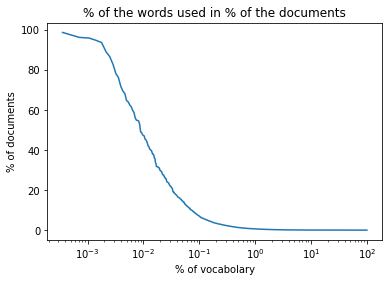

In [149]:
# What % of the reviews use what % of the vocab
vocab_size = len(cnt2)
sample_size = 25000

y = [c/sample_size * 100 for (w, c) in cnt2.most_common()]
x = [c/vocab_size * 100 for c in range(1, vocab_size+1)]
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(x, y)
ax.set_title("% of the words used in % of the documents")
ax.set_xscale('log')
ax.set_xlabel("% of vocabolary")
ax.set_ylabel("% of documents")

### 1.4 Preprocessing and vectorization

In [150]:
# I think to put this into own .PY file and import from there
class text_preprocessor():
    def __init__(self):
        import nltk
        import re
        import string
        
        nltk.download('stopwords')
        nltk.download('wordnet')
        from nltk.corpus import stopwords
        ", ".join(stopwords.words('english'))
        from nltk.stem.wordnet import WordNetLemmatizer 
        
        self.stop_words = set(stopwords.words('english'))
        
        self.punctuation = string.punctuation
        
        self.emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
        
        # src : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
        self.emoticons = {
            u":‑\)":"Happy face or smiley",
            u":\)":"Happy face or smiley",
            u":-\]":"Happy face or smiley",
            u":\]":"Happy face or smiley",
            u":-3":"Happy face smiley",
            u":3":"Happy face smiley",
            u":->":"Happy face smiley",
            u":>":"Happy face smiley",
            u"8-\)":"Happy face smiley",
            u":o\)":"Happy face smiley",
            u":-\}":"Happy face smiley",
            u":\}":"Happy face smiley",
            u":-\)":"Happy face smiley",
            u":c\)":"Happy face smiley",
            u":\^\)":"Happy face smiley",
            u"=\]":"Happy face smiley",
            u"=\)":"Happy face smiley"
        }

    def lower_case(self, text):
        return str.lower(text)
    
    def remove_punctuation(self, text):
        return text.translate(str.maketrans('', '', self.punctuation))
    
    def remove_stopwords(self, text):
        return [word for word in text if word not in self.stop_words]
    
    def remove_words(self, text, freq_words):
        return [word for word in text if word not in freq_words]
    
    def remove_emoji(self, text):
        # src: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
        return self.emoji_pattern.sub(r'', text)
    
    
    def remove_emoticons(self, text):
        import re
        # src : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
        emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in self.emoticons) + u')')
        return emoticon_pattern.sub(r'', text)
    
    def convert_emoticons(self, text):
        # src : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
        for emot in self.emoticons:
            text = re.sub(u'('+emot+')', "_".join(self.emoticons[emot].replace(",","").split()), text)
        return text
    
    def lemmatization(self, text):
        lemmatizer = WordNetLemmatizer()
        tokens = word_tokenize(text)
        for i in ['v','n','a']:
            tokens = [lemmatizer.lemmatize(word, i) for word in tokens]
        return tokens
    
    def expand_contractions(self, text):
        text = re.sub(r"i'm", " i am ", text)
        text = re.sub(r" im ", " i am ", text)
        text = re.sub(r"\: p", "", text)
        text = re.sub(r" ive ", " i have ", text)
        text = re.sub(r" he's ", " he is ", text)
        text = re.sub(r" she's ", " she is ", text)
        text = re.sub(r" that's ", " that is ", text)
        text = re.sub(r" what's ", " what is ", text)
        text = re.sub(r" where's ", " where is ", text)
        text = re.sub(r" haven't ", " have not ", text)
        text = re.sub(r" ur ", " you are ", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r" won't ", " will not ", text)
        text = re.sub(r" wouldn't ", " would not ", text)
        text = re.sub(r" can't ", " cannot ", text)
        text = re.sub(r" couldn't ", " could not ", text)
        text = re.sub(r" don't ", " do not ", text)
        text = re.sub(r" didn't ", " did not ", text)
        text = re.sub(r" doesn't ", " does not ", text)
        text = re.sub(r" isn't ", " is not ", text)
        text = re.sub(r" it's ", " it is ", text)
        text = re.sub(r" who's ", " who is ", text)
        text = re.sub(r" there's ", " there is ", text)
        text = re.sub(r" weren't ", " were not ", text)
        text = re.sub(r" ok ", " okay ", text)
        text = re.sub(r" you're ", " you are ", text)
        text = re.sub(r" c'mon ", " come on ", text)
        text = re.sub(r"in'", "ing", text)
        text = re.sub(r"\'s", " s", text)
        return text
    
    def remove_urls(self, text):
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        return url_pattern.sub(r'', text)
    
    # preprocessing IMDB reviews
    def preprocess_imdb_reviews(self, df, max_df, min_df, n_freq_words = 10, n_rare_words = 10):
        df['processed'] = df['review'].apply(lambda text: self.lower_case(text))
        df['processed'] = df['processed'].apply(lambda text: self.expand_contractions(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_urls(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_emoji(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_punctuation(text))
        df['tokenized'] = df['processed'].apply(lambda text: self.lemmatization(text))
        df['tokenized'] = df['tokenized'].apply(lambda text: self.remove_stopwords(text))
        
        # We tokenize the strings first after lemmatization. And when we tokenize the words we don't
        # convert it to string again. That is because we have to tokenize in TF-IDF vectorization later
        # anyway so no need to use extra time on that.

        from collections import Counter
        cnt = Counter()
        cnt2 = Counter()
        for text in df['tokenized'].values:
            # Counting the words
            for word in text:
                cnt[word] += 1
            # Counting in how many reviews the word appears
            for word in set(text):
                cnt2[word] += 1


        # Removing most frequent words
        freq_words = set([w for (w, wc) in cnt.most_common(n_freq_words)])
        df['tokenized'] = df['tokenized'].apply(lambda text: self.remove_words(text, freq_words))

        # Removing rarest words
        rare_words = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
        df['tokenized'] = df['tokenized'].apply(lambda text: self.remove_words(text, rare_words))


        # Remove words used in >90% and <5% of the reviews
        curb_max_amount = len(df) * max_df
        curb_min_amount = len(df) * min_df

        curb_words = set([w for (w, wc) in cnt2.most_common() if wc > curb_max_amount or wc < curb_min_amount])

        df['tokenized'] = df['tokenized'].apply(lambda text: self.remove_words(text, curb_words))

        return df


In [151]:
# TF-IDF VECTORIZER CLASS
import math
from collections import Counter
import numpy as np
from nltk import FreqDist

class TfIdfVectorizer:
    def __init__(self, df):
        self._idfs = self.prepare_idfs(df)
        self._vocab = self.prepare_vocab(df)
    
    @property
    def idfs(self):
        return self._idfs
    
    @idfs.setter
    def idfs(self, idfs):
        self._idfs = idfs
    
    @property
    def vocab(self):
        return self._vocab
    
    @vocab.setter
    def vocab(self, vocab):
        self._vocab = vocab
    
    # Prepare and return vocab out of corpus
    def prepare_vocab(self, df):
        # Prepare the vocab
        self.vocab = set(np.hstack(df['tokenized'].values))
        self.vocab = dict.fromkeys(self.vocab, 0)
        self.vocab.update((k, i) for i, k in enumerate(self.vocab))
        return self.vocab
    
    # Prepare and return idfs out of corpus
    def prepare_idfs(self, df):
        # Counting how many reviews a word appears ins
        cnt = Counter()
        for text in df["tokenized"].values:
            for word in set(text):
                cnt[word] += 1
        # Preparing the IDF vector
        size = len(df)
        self.idfs = dict()
        for w, c in cnt.items():
            self.idfs[w] = 0 if c == 0 else math.log(size / c)
        return self.idfs


    # TF-IDF vectorize a single text, returning an np.array
    def tf_idf_vectorize(self, text):
        freq_dist = FreqDist(text)
        vector = np.zeros(len(self.vocab))
        for w, c in freq_dist.items():
            if w in self.vocab:
                vector[self.vocab[w]] = c * self.idfs[w]
        return vector


    # One hot encode labels
    def one_hot_encode(self, label, nr_of_labels):
        arr = np.zeros(nr_of_labels, dtype=int)
        arr[label] = 1
        return arr

    # Vectorize all in the dataset
    def tf_idf_vectorize_all(self, df):
        df['vectors'] = df['tokenized'].apply(lambda text: self.tf_idf_vectorize(text))
        return df
    
    # Turn all labels into one hot encoded arrays
    def one_hot_encode_all(self, df, nr_of_labels):
        df['label-encoded'] = df['label'].apply(lambda label: self.one_hot_encode(label, nr_of_labels))
        return df


    



In [152]:
#Using the preprocessor
preprocessor = text_preprocessor()
train_set_processed = preprocessor.preprocess_imdb_reviews(train_set, 0.9, 0.05)
test_set_processed = preprocessor.preprocess_imdb_reviews(test_set, 0.9, 0.05)
valid_set_processed = preprocessor.preprocess_imdb_reviews(valid_set, 0.9, 0.05)

valid_set_processed

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,review,rate,label,processed,tokenized
0,It's Bad for Ya really showcases more of Georg...,10,1,it s bad for ya really showcases more of georg...,"[bad, really, really, still, lose, year, comed..."
1,It might be a stretch saying this as a die-har...,10,1,it might be a stretch saying this as a diehard...,"[might, say, fan, write, bad, best, yet, back,..."
2,"I can't say I enjoyed this as much as ""The Big...",7,1,i cannot say i enjoyed this as much as the big...,"[say, enjoy, much, big, little, laugh, sense, ..."
3,This movie was sooooooo good! It was hilarious...,10,1,this movie was sooooooo good it was hilarious ...,"[many, watch, john, love, guy, love, go, defin..."
4,Jean Renoir's homage to the Paris of the late ...,9,1,jean renoir s homage to the paris of the late ...,"[late, beautiful, many, way, appear, end, men,..."
...,...,...,...,...,...
12495,I occasionally let my kids watch this garbage ...,1,0,i occasionally let my kids watch this garbage ...,"[let, kid, watch, understand, show, minute, an..."
12496,When all we have anymore is pretty much realit...,1,0,when all we have anymore is pretty much realit...,"[pretty, much, tv, show, people, reason, worth..."
12497,The basic genre is a thriller intercut with an...,3,0,the basic genre is a thriller intercut with an...,"[try, lot, use, title, bring, small, surprise,..."
12498,Four things intrigued me as to this film - fir...,3,0,four things intrigued me as to this film firs...,"[thing, star, always, watch, feature, new, new..."


In [153]:
valid_set_processed

,review,rate,label,processed,tokenized
0,It's Bad for Ya really showcases more of Georg...,10,1,it s bad for ya really showcases more of georg...,"[bad, really, really, still, lose, year, comed..."
1,It might be a stretch saying this as a die-har...,10,1,it might be a stretch saying this as a diehard...,"[might, say, fan, write, bad, best, yet, back,..."
2,"I can't say I enjoyed this as much as ""The Big...",7,1,i cannot say i enjoyed this as much as the big...,"[say, enjoy, much, big, little, laugh, sense, ..."
3,This movie was sooooooo good! It was hilarious...,10,1,this movie was sooooooo good it was hilarious ...,"[many, watch, john, love, guy, love, go, defin..."
4,Jean Renoir's homage to the Paris of the late ...,9,1,jean renoir s homage to the paris of the late ...,"[late, beautiful, many, way, appear, end, men,..."
...,...,...,...,...,...
12495,I occasionally let my kids watch this garbage ...,1,0,i occasionally let my kids watch this garbage ...,"[let, kid, watch, understand, show, minute, an..."
12496,When all we have anymore is pretty much realit...,1,0,when all we have anymore is pretty much realit...,"[pretty, much, tv, show, people, reason, worth..."
12497,The basic genre is a thriller intercut with an...,3,0,the basic genre is a thriller intercut with an...,"[try, lot, use, title, bring, small, surprise,..."
12498,Four things intrigued me as to this film - fir...,3,0,four things intrigued me as to this film firs...,"[thing, star, always, watch, feature, new, new..."


In [154]:
# Get the IDF values and VOCAB vector
vectorizer = TfIdfVectorizer(train_set_processed)
idfs = vectorizer.idfs
vocab = vectorizer.vocab


# Vectorizing train set and test set
train_set_vectorized = vectorizer.tf_idf_vectorize_all(train_set_processed)

test_set_vectorized = vectorizer.tf_idf_vectorize_all(test_set_processed)

valid_set_vectorized = vectorizer.tf_idf_vectorize_all(valid_set_processed)



## 2. Set up genetic algorithm


### 2.1 Classifier
There are a lot of classifiers. I haven't any experience in most of them, just a little familiar with Neural Network thus this is what I did choose.

In [155]:
class Classifier:
    def __init__(self, idfs, vocab):
        self.idfs = idfs
        self.vocab = vocab
        self.ws_1 = 0
        self.ws_2 = 0
    
    def relu(self, x):
        return (x > 0) * x 

    # Initializing weights
    def init_weights(self, hidden_nodes):
        self.ws_1 = np.random.rand(len(vocab), hidden_nodes) - 0.5
        self.ws_2 = np.random.rand(hidden_nodes, 2) - 0.5
    
    def sigmoid(self, x):
        from scipy import special
        return special.expit(x)
    
    def softmax(self, x):
        import numpy as np
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def cross_entropy(self, p, o):
        import numpy as np
        y = [0,0]
        y[o] = 1
        return -(sum(np.nan_to_num(y*np.log(p))))
    
    def predict_single_row(self, x, y, w_1, w_2):
        #forward pass/prediction
        layer_1 = self.relu(x.dot(w_1))
        layer_out = self.softmax(layer_1.dot(w_2))
        return layer_out
    
    def get_predicted_label(self, p):
        return np.argmax(p)
    
    def predict_whole_set(self, df, ws_1, ws_2):
        df['predictions'] = df.apply(lambda vec: self.predict_single_row(vec.vectors, vec.label, ws_1, ws_2), axis=1)
        df['CE-loss'] = df.apply(lambda x: self.cross_entropy(x.predictions, x.label), axis=1)
        df['predicted-vals'] = df.apply(lambda p: self.get_predicted_label(p.predictions), axis=1)
        mean_loss = df['CE-loss'].mean()
        return mean_loss, df
    

        

In [156]:
# Initialize classifier
classifier = Classifier(idfs, vocab)

In [157]:
# Test run classifier
classifier.init_weights(8)

In [158]:
pre_training_CEL, output_df = classifier.predict_whole_set(valid_set_vectorized, classifier.ws_1, classifier.ws_2)

In [159]:
print(pre_training_CEL)
output_df

pre_training_nr_of_correct = output_df[output_df['label'] == output_df['predicted-vals']].count().values[0]
pre_training_accuracy = pre_training_nr_of_correct / len(output_df)

pre_training_accuracy

1.8570765042031592


0.50104

### 2.2 Chromosome
It's just some weights that'll be used for classification

In [160]:
class Chromosome:
    # x_pos and y_pos are the features of our chromosome
    def __init__(self, ws_1, ws_2):
        self._fitness = 0
        self._ws_1 = ws_1
        self._ws_2 = ws_2
    
    # Getters and setters
    @property
    def ws_1(self):
        return self._ws_1
    
    @ws_1.setter
    def ws_1(self, value):
        self._ws_1 = value
    
    @property
    def ws_2(self):
        return self._ws_2
    
    @ws_2.setter
    def ws_2(self, value):
        self._ws_2 = value
    
    @property
    def fitness(self):
        return self._fitness
    
    @fitness.setter
    def fitness(self, value):
        self._fitness = value
    
    def assign_fitness(self, classifier, data_set):
        import math
        loss, _ = classifier.predict_whole_set(data_set, self.ws_1, self.ws_2)
        self.fitness = 1/loss #0 if loss <= 0 or loss == float('inf') else -math.log(1 / loss)
    
    # produce a new offspring from 2 parents
    def crossover(self, other):
        r = 0
        
        min_mat_1 = np.minimum(self.ws_1, other.ws_1)
        max_mat_1 = np.maximum(self.ws_1, other.ws_1)
        min_mat_2 = np.minimum(self.ws_2, other.ws_2)
        max_mat_2 = np.maximum(self.ws_2, other.ws_2)
        
        ws_1 = np.random.uniform(min_mat_1-r, max_mat_1+r)
        ws_2 = np.random.uniform(min_mat_2-r, max_mat_2+r) 
        
        offspring = Chromosome(ws_1, ws_2)
        return offspring

    # mutate the individual
    def mutate(self):
        np.random.shuffle(self.ws_1)
        self.ws_1 = self.ws_1 + np.random.uniform(-1, 1, size=self.ws_1.shape)
        np.random.shuffle(self.ws_2)
        self.ws_2 = self.ws_2 + np.random.uniform(-1, 1, size=self.ws_2.shape)
        return
    

    



### 2.3 Genetic Algorithm Engine

In [175]:
class GAEngine:
    def __init__(self):
        self._population = []
        self._generations = 0

    def make_initial_population(self, population_size):       
        for i in range(population_size):
            ws_1, ws_2 = self.init_weights()
            self.population.append(Chromosome(ws_1, ws_2))

        
    @property
    def generations(self):
        return self._generations
    
    @generations.setter
    def generations(self, g):
        self._generations = g
    
    @property
    def population(self):
        return self._population
    
    @population.setter
    def population(self, p):
        self._population = p
    
    
    # Initializing weights
    def init_weights(self):
        hidden_nodes = 8
        ws_1 = np.random.rand(len(vocab), hidden_nodes) - 0.5
        ws_2 = np.random.rand(hidden_nodes, 2) - 0.5
        return ws_1, ws_2
    

    # selection code goes here...
    def do_crossover(self, no_of_offspring):
        import random
        population_size = len(self.population)
        # Here we combine elitism selection with roulette wheel
        # We carry ca 20 % of the most fit over to the next generation.
        # Then we use roulette wheel because we want diversity too.
        # We want diversity because it's hard to predict optimal weights
        
        # Get the top ca 20 % fittest.
        rate_to_keep = 0.2
        keep_nr = int(population_size * rate_to_keep)
        self.population = sorted(self.population, key=lambda x: x.fitness)
        new_generation = self.population[-keep_nr:]
        
        # new_generation = list()

        # Then we make offsprings based on random choices with weights.
        # We raise the exponent fitness to 2 to make the differences more
        # Since we are using "roulette wheel" in selection, we want to increase the chance of
        # the most fit to be selected.
        fitness_values = [x.fitness**2 for x in self.population]
        for i in range(no_of_offspring):
            parent1, parent2 = random.choices(self.population, weights=fitness_values, k=2)
            offspring = parent1.crossover(parent2)
            new_generation.append(offspring)
        
        self.population = new_generation
        return
    
    
    # fitness calculation goes here...
    def assign_fitness(self, classifier, data_set):
        # Fitness is 987 substracted by distance to closest food
        # We want the chromosomes close to some food to survive, not close to all foods on average.
        for ch in self.population:
            ch.assign_fitness(classifier, data_set)
        return
    
    def get_population(self):
        return self.population
    
    def get_best_chromosome(self):
        ch = max(self.population, key=lambda x: x.fitness)
        return ch
    
    def training_routine(self, init_population, nr_of_generations, 
                        no_of_mutation, rate_of_crossover):
        self.make_initial_population(init_population)
        self.generations = nr_of_generations
        
        cels = list()


        for i in range(self.generations):
            self.assign_fitness(classifier, test_set_vectorized)
            cels.append(self.get_best_chromosome().fitness)
            # ca 60 % of population to do crossover
            no_of_crossover = int(rate_of_crossover * len(self.population))
            self.do_crossover(no_of_crossover)


            # High number of mutations for more variations
            for i in range(no_of_mutation):
                index = random.randint(0, len(self.population)-1)
                self.population[index].mutate()
            
            

        # Assign fitness last time before getting the best chromosome
        self.assign_fitness(classifier, test_set_vectorized)
        cels.append(self.get_best_chromosome().fitness)
        return self.get_best_chromosome(), cels


In [176]:
# Here I run the GA engine
ga = GAEngine()
gens = 20
ch, cels = ga.training_routine(20, gens, 4, 0.6)
cels

KeyboardInterrupt: 

In [173]:
print(ch.fitness)

1.3722897413006347


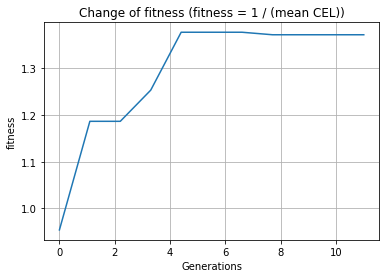

In [174]:
# Plotting increase of fitness in training
x = np.linspace(0, gens+1, gens+1)
fig, ax = plt.subplots(1, 1)
ax.plot(x, cels, label='fitness')

plt.xlabel("Generations")
plt.ylabel("fitness")
plt.title("Change of fitness (fitness = 1 / (mean CEL))")

plt.grid()
plt.show()


## 3. Validation

In [169]:
post_training_CEL, output_df = classifier.predict_whole_set(valid_set_vectorized, ch.ws_1, ch.ws_2)

In [170]:
post_training_nr_of_correct = output_df[output_df['label'] == output_df['predicted-vals']].count().values[0]
post_training_accuracy = post_training_nr_of_correct / len(output_df)

print("Accuracy before training: ", pre_training_accuracy)
print("Accuracy after training: ", post_training_accuracy)
print("CEL before training", pre_training_CEL)
print("CEL after training", post_training_CEL)

Accuracy before training:  0.50104
Accuracy after training:  0.49408
CEL before training 1.8570765042031592
CEL after training 0.8130857609149558


In [167]:
output_df

,review,rate,label,processed,tokenized,vectors,predictions,CE-loss,predicted-vals
0,It's Bad for Ya really showcases more of Georg...,10,1,it s bad for ya really showcases more of georg...,"[bad, really, really, still, lose, year, comed...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6883234202263518, 0.3116765797736481]",1.165789,0
1,It might be a stretch saying this as a die-har...,10,1,it might be a stretch saying this as a diehard...,"[might, say, fan, write, bad, best, yet, back,...","[0.0, 0.0, 0.0, 1.7646891977053918, 0.0, 0.0, ...","[0.7989135081921105, 0.2010864918078896]",1.604020,0
2,"I can't say I enjoyed this as much as ""The Big...",7,1,i cannot say i enjoyed this as much as the big...,"[say, enjoy, much, big, little, laugh, sense, ...","[0.0, 0.0, 0.0, 3.5293783954107836, 0.0, 0.0, ...","[0.6893847238014845, 0.3106152761985155]",1.169200,0
3,This movie was sooooooo good! It was hilarious...,10,1,this movie was sooooooo good it was hilarious ...,"[many, watch, john, love, guy, love, go, defin...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.762...","[0.5, 0.5]",0.693147,0
4,Jean Renoir's homage to the Paris of the late ...,9,1,jean renoir s homage to the paris of the late ...,"[late, beautiful, many, way, appear, end, men,...","[2.76843304264985, 2.5352740571517867, 0.0, 1....","[0.6383392436011415, 0.36166075639885853]",1.017049,0
...,...,...,...,...,...,...,...,...,...
12495,I occasionally let my kids watch this garbage ...,1,0,i occasionally let my kids watch this garbage ...,"[let, kid, watch, understand, show, minute, an...","[0.0, 0.0, 0.0, 0.0, 0.0, 2.3653119229023507, ...","[0.4162229157251895, 0.5837770842748106]",0.876534,1
12496,When all we have anymore is pretty much realit...,1,0,when all we have anymore is pretty much realit...,"[pretty, much, tv, show, people, reason, worth...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.3807130696654118, 0.6192869303345883]",0.965709,1
12497,The basic genre is a thriller intercut with an...,3,0,the basic genre is a thriller intercut with an...,"[try, lot, use, title, bring, small, surprise,...","[0.0, 0.0, 1.6259738810742, 0.0, 2.57072601023...","[0.5186512769674743, 0.48134872303252574]",0.656524,0
12498,Four things intrigued me as to this film - fir...,3,0,four things intrigued me as to this film firs...,"[thing, star, always, watch, feature, new, new...","[0.0, 0.0, 1.6259738810742, 0.0, 0.0, 0.0, 0.0...","[0.5899794301410015, 0.41002056985899843]",0.527668,0
